In [10]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import torch
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image


### Exploring Dataset

In [2]:
train = h5py.File('Data/train_signs.h5', 'r')

In [3]:
train['train_set_x'].shape ## 1080 sample in train set 

(1080, 64, 64, 3)

In [4]:

train['train_set_y'].shape

(1080,)

In [5]:

test = h5py.File('Data/test_signs.h5', 'r')

In [6]:
test['test_set_x'].shape ## 120 samples in test set

(120, 64, 64, 3)

In [7]:
train['train_set_x']

<HDF5 dataset "train_set_x": shape (1080, 64, 64, 3), type "|u1">

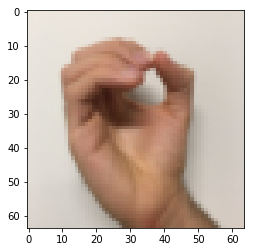

In [8]:

imgplot = plt.imshow(train['train_set_x'][1])

In [9]:
train['train_set_y'][1]

0

In [10]:
### Classes in the Data
print('No of Classes are :' + str(len(set(train['train_set_y']))))
print(set(train['train_set_y']))

No of Classes are :6
{0, 1, 2, 3, 4, 5}


### Dataloader in pytorch ####

In [11]:
class Img_Dataset(Dataset):
    
    def __init__(self, img_x, img_y):
        self.img_x = torch.Tensor(img_x)
        self.img_y = torch.Tensor(img_y)
        
    def __getitem__(self, index):
        return (self.img_x[index], self.img_y[index])


    def __len__(self):
        return len(self.img_x)

In [12]:
train_data = h5py.File('Data/train_signs.h5', 'r')
train_x, train_y = train_data['train_set_x'], train_data['train_set_y']
train_dataset = Img_Dataset(train_x, train_y)
train_dl = DataLoader(train_dataset, batch_size=16, drop_last = True, shuffle=True)

In [13]:
test_data = h5py.File('Data/test_signs.h5', 'r')
test_x, test_y = test_data['test_set_x'], test_data['test_set_y']
test_dataset = Img_Dataset(test_x, test_y)
test_dl = DataLoader(test_dataset, batch_size=16, drop_last=True, shuffle=False)

In [14]:
torch.manual_seed(100)

In [15]:
### CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [16]:
class Image_Classifier(torch.nn.Module):
    def __init__(self):
        super(Image_Classifier, self).__init__()
        
        self.Z1 = torch.nn.Conv2d(3, 12, 3, stride=1, padding=1)
        self.A1 = torch.nn.ReLU(self.Z1)   
        self.P1 = torch.nn.MaxPool2d(2, stride=2)
        
        self.Z2 = torch.nn.Conv2d(12, 18, 4, stride=1, padding=1)
        self.A2 = torch.nn.ReLU(self.Z2)
        self.P2 = torch.nn.MaxPool2d(2, stride=2)
        self.linear1 = torch.nn.Linear(4050, 720, bias=True)
        self.A3 = torch.nn.ReLU(self.linear1)
        self.linear2 = torch.nn.Linear(720, 100, bias=True)
        self.A4 = torch.nn.ReLU(self.linear2)
        self.linear3 = torch.nn.Linear(100, 6, bias=True)
        

            
    def forward(self, data):

        layer1_1 = self.Z1(data)
        
        layer1_2 = self.A1(layer1_1)
        
        layer1_3 = self.P1(layer1_2)

        
        layer2_1 = self.Z2(layer1_3)

        layer2_2 = self.A2(layer2_1)
        layer2_3 = self.P2(layer2_2)
        
        flatten = layer2_3.view(layer2_3.size()[0], 4050 )

        lin_out_1 = self.linear1(flatten)
        layer3_1 = self.A3(lin_out_1)
        layer3_2 = self.A4(self.linear2(layer3_1))
        out = self.linear3(layer3_2)
    
        return F.log_softmax(out)
        
    

In [17]:
model = Image_Classifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.NLLLoss()


In [18]:
for i in range(10):
    loss_avg = []
    acc_avg = []
    model.train()
    for batch in tqdm(train_dl):
        #print(batch[0])
    
        batch_dat = batch[0].permute(0, 3, 1, 2)
    
        # in your training loop:
        optimizer.zero_grad()   # zero the gradient buffers
        predict = model.forward(batch_dat)

        
        pred = np.argmax(predict.detach().numpy(), axis=1)

        count = sum(sum([pred == batch[1].long().detach().numpy()]))
     
        
        acc = count/len(pred)
        acc_avg.append(acc)
        loss = criterion(predict, batch[1].long())
        
    
        loss_avg.append(loss.detach().cpu())
        loss.backward()
        
        optimizer.step()  
    

    print('Avg Train Loss for Epoch : '+str(i)+" is "+str(np.mean(loss_avg)))
    print('Avg Train accuracy for Epoch : '+str(i)+" is "+str(np.mean(acc_avg)))
    ### Validation after each epoch 
    
    model.eval()
    val_acc = []
    for val_batch in test_dl:
        val_dat = val_batch[0].permute(0, 3, 1, 2)
        with torch.no_grad():
            predict = model.forward(val_dat)
            pred = np.argmax(predict.detach().numpy(), axis=1)
            count = sum(sum([pred == val_batch[1].long().detach().numpy()]))
            acc = count/len(pred)
            val_acc.append(acc)
            
    print('Avg Validation accuracy for Epoch : '+str(i)+" is "+str(np.mean(val_acc)))
     

  1%|▏         | 1/67 [00:00<00:12,  5.43it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  7%|▋         | 5/67 [00:00<00:07,  8.03it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 13%|█▎        | 9/67 [00:00<00:05, 10.97it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 19%|█▉        | 13/67 [00:00<00:04, 12.84it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 25%|██▌       | 17/67 [00:01<00:03, 14.67it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 31%|███▏      | 21/67 [00:01<00:02, 15.44it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 37%|███▋      | 25/67 [00:01<00:02, 15.73it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 43%|████▎     | 29/67 [00:01<00:02, 14.79it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 46%|████▋     | 31/67 [00:02<00:02, 14.64it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 52%|█████▏    | 35/67 [00:02<00:02, 15.40it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 58%|█████▊    | 39/67 [00:02<00:01, 15.75it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 64%|██████▍   | 43/67 [00:02<00:01, 15.93it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 70%|███████   | 47/67 [00:03<00:01, 15.67it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 76%|███████▌  | 51/67 [00:03<00:01, 14.80it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 82%|████████▏ | 55/67 [00:03<00:00, 14.18it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 85%|████████▌ | 57/67 [00:03<00:00, 13.81it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 91%|█████████ | 61/67 [00:04<00:00, 14.52it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 97%|█████████▋| 65/67 [00:04<00:00, 14.83it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


100%|██████████| 67/67 [00:04<00:00, 14.65it/s]


torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Train Loss for Epoch : 0 is 6.8656993
Avg Train accuracy for Epoch : 0 is 0.36100746268656714
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  3%|▎         | 2/67 [00:00<00:03, 16.97it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 0 is 0.5535714285714286
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  9%|▉         | 6/67 [00:00<00:03, 16.49it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 15%|█▍        | 10/67 [00:00<00:03, 16.10it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 21%|██        | 14/67 [00:00<00:03, 16.12it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 27%|██▋       | 18/67 [00:01<00:03, 15.09it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 33%|███▎      | 22/67 [00:01<00:02, 15.88it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 39%|███▉      | 26/67 [00:01<00:02, 16.14it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 45%|████▍     | 30/67 [00:01<00:02, 16.07it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 51%|█████     | 34/67 [00:02<00:01, 16.56it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 57%|█████▋    | 38/67 [00:02<00:01, 16.35it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 63%|██████▎   | 42/67 [00:02<00:01, 15.87it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 69%|██████▊   | 46/67 [00:02<00:01, 16.40it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 75%|███████▍  | 50/67 [00:03<00:01, 16.05it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 81%|████████  | 54/67 [00:03<00:00, 15.67it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 87%|████████▋ | 58/67 [00:03<00:00, 14.90it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 90%|████████▉ | 60/67 [00:03<00:00, 14.31it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 96%|█████████▌| 64/67 [00:04<00:00, 15.14it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  0%|          | 0/67 [00:00<?, ?it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Train Loss for Epoch : 1 is 0.76446503
Avg Train accuracy for Epoch : 1 is 0.7313432835820896
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 1 is 0.8125
torch.Size([16, 18, 15, 15])


  6%|▌         | 4/67 [00:00<00:03, 16.82it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 12%|█▏        | 8/67 [00:00<00:03, 16.01it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 15%|█▍        | 10/67 [00:00<00:03, 15.20it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])

 21%|██        | 14/67 [00:00<00:03, 15.55it/s]


torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 27%|██▋       | 18/67 [00:01<00:03, 15.86it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 33%|███▎      | 22/67 [00:01<00:02, 15.97it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 36%|███▌      | 24/67 [00:01<00:02, 14.64it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 42%|████▏     | 28/67 [00:01<00:02, 14.45it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 48%|████▊     | 32/67 [00:02<00:02, 14.25it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 54%|█████▎    | 36/67 [00:02<00:02, 14.36it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 57%|█████▋    | 38/67 [00:02<00:02, 14.46it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 63%|██████▎   | 42/67 [00:02<00:01, 14.79it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 66%|██████▌   | 44/67 [00:02<00:01, 13.74it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 72%|███████▏  | 48/67 [00:03<00:01, 14.55it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 78%|███████▊  | 52/67 [00:03<00:01, 14.85it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 84%|████████▎ | 56/67 [00:03<00:00, 15.96it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 90%|████████▉ | 60/67 [00:04<00:00, 15.47it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 96%|█████████▌| 64/67 [00:04<00:00, 15.48it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  0%|          | 0/67 [00:00<?, ?it/s]

torch.Size([16, 18, 15, 15])
Avg Train Loss for Epoch : 2 is 0.3338078
Avg Train accuracy for Epoch : 2 is 0.8861940298507462
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 2 is 0.8125
torch.Size([16, 18, 15, 15])


  6%|▌         | 4/67 [00:00<00:03, 15.90it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 12%|█▏        | 8/67 [00:00<00:03, 16.22it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 18%|█▊        | 12/67 [00:00<00:03, 16.47it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 24%|██▍       | 16/67 [00:00<00:03, 16.49it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 30%|██▉       | 20/67 [00:01<00:02, 17.11it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 36%|███▌      | 24/67 [00:01<00:02, 16.90it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 42%|████▏     | 28/67 [00:01<00:02, 16.27it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 48%|████▊     | 32/67 [00:01<00:02, 16.47it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 54%|█████▎    | 36/67 [00:02<00:01, 16.30it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 60%|█████▉    | 40/67 [00:02<00:01, 16.12it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 66%|██████▌   | 44/67 [00:02<00:01, 16.27it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 72%|███████▏  | 48/67 [00:02<00:01, 16.39it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 78%|███████▊  | 52/67 [00:03<00:00, 16.95it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 84%|████████▎ | 56/67 [00:03<00:00, 17.18it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 90%|████████▉ | 60/67 [00:03<00:00, 17.49it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 96%|█████████▌| 64/67 [00:03<00:00, 17.26it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  0%|          | 0/67 [00:00<?, ?it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Train Loss for Epoch : 3 is 0.20483817
Avg Train accuracy for Epoch : 3 is 0.9300373134328358
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 3 is 0.8214285714285714


  3%|▎         | 2/67 [00:00<00:03, 17.87it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  9%|▉         | 6/67 [00:00<00:03, 17.55it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 15%|█▍        | 10/67 [00:00<00:03, 16.61it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 21%|██        | 14/67 [00:00<00:03, 16.53it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 27%|██▋       | 18/67 [00:01<00:02, 17.48it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 33%|███▎      | 22/67 [00:01<00:02, 17.45it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 39%|███▉      | 26/67 [00:01<00:02, 17.40it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 45%|████▍     | 30/67 [00:01<00:02, 17.05it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 51%|█████     | 34/67 [00:01<00:01, 17.46it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 57%|█████▋    | 38/67 [00:02<00:01, 17.83it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 63%|██████▎   | 42/67 [00:02<00:01, 17.95it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 69%|██████▊   | 46/67 [00:02<00:01, 17.81it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 75%|███████▍  | 50/67 [00:02<00:00, 17.36it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 81%|████████  | 54/67 [00:03<00:00, 16.33it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 87%|████████▋ | 58/67 [00:03<00:00, 16.12it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 93%|█████████▎| 62/67 [00:03<00:00, 17.24it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 99%|█████████▊| 66/67 [00:03<00:00, 17.75it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  0%|          | 0/67 [00:00<?, ?it/s]

Avg Train Loss for Epoch : 4 is 0.121461324
Avg Train accuracy for Epoch : 4 is 0.960820895522388
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 4 is 0.8660714285714286
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  6%|▌         | 4/67 [00:00<00:04, 15.35it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 12%|█▏        | 8/67 [00:00<00:03, 15.80it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 18%|█▊        | 12/67 [00:00<00:03, 15.42it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 24%|██▍       | 16/67 [00:00<00:03, 16.47it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 30%|██▉       | 20/67 [00:01<00:02, 15.95it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 36%|███▌      | 24/67 [00:01<00:02, 15.80it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 42%|████▏     | 28/67 [00:01<00:02, 16.10it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 48%|████▊     | 32/67 [00:01<00:02, 16.64it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 54%|█████▎    | 36/67 [00:02<00:01, 17.05it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 60%|█████▉    | 40/67 [00:02<00:01, 16.40it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 66%|██████▌   | 44/67 [00:02<00:01, 16.43it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 72%|███████▏  | 48/67 [00:02<00:01, 17.01it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 78%|███████▊  | 52/67 [00:03<00:00, 17.01it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 84%|████████▎ | 56/67 [00:03<00:00, 16.53it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 90%|████████▉ | 60/67 [00:03<00:00, 16.61it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 96%|█████████▌| 64/67 [00:03<00:00, 17.16it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  0%|          | 0/67 [00:00<?, ?it/s]

torch.Size([16, 18, 15, 15])
Avg Train Loss for Epoch : 5 is 0.07784355
Avg Train accuracy for Epoch : 5 is 0.9785447761194029
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 5 is 0.8571428571428571
torch.Size([16, 18, 15, 15])


  6%|▌         | 4/67 [00:00<00:03, 16.17it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 12%|█▏        | 8/67 [00:00<00:03, 16.09it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 18%|█▊        | 12/67 [00:00<00:03, 16.85it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 24%|██▍       | 16/67 [00:00<00:02, 17.40it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 30%|██▉       | 20/67 [00:01<00:02, 16.97it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 36%|███▌      | 24/67 [00:01<00:02, 16.91it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 42%|████▏     | 28/67 [00:01<00:02, 17.20it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 48%|████▊     | 32/67 [00:01<00:02, 17.22it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 54%|█████▎    | 36/67 [00:02<00:01, 16.87it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 60%|█████▉    | 40/67 [00:02<00:01, 17.21it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 66%|██████▌   | 44/67 [00:02<00:01, 16.81it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 72%|███████▏  | 48/67 [00:02<00:01, 17.20it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 78%|███████▊  | 52/67 [00:03<00:00, 17.63it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 84%|████████▎ | 56/67 [00:03<00:00, 17.81it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 90%|████████▉ | 60/67 [00:03<00:00, 17.30it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 96%|█████████▌| 64/67 [00:03<00:00, 17.25it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  0%|          | 0/67 [00:00<?, ?it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Train Loss for Epoch : 6 is 0.059200834
Avg Train accuracy for Epoch : 6 is 0.9794776119402985
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 6 is 0.8035714285714286


  3%|▎         | 2/67 [00:00<00:04, 15.62it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  9%|▉         | 6/67 [00:00<00:03, 16.54it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 15%|█▍        | 10/67 [00:00<00:03, 16.98it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 21%|██        | 14/67 [00:00<00:03, 16.14it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 27%|██▋       | 18/67 [00:01<00:03, 15.76it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 33%|███▎      | 22/67 [00:01<00:02, 15.92it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 39%|███▉      | 26/67 [00:01<00:02, 15.95it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 45%|████▍     | 30/67 [00:01<00:02, 15.98it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 51%|█████     | 34/67 [00:02<00:02, 15.44it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 57%|█████▋    | 38/67 [00:02<00:01, 15.10it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 63%|██████▎   | 42/67 [00:02<00:01, 15.11it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 69%|██████▊   | 46/67 [00:02<00:01, 15.25it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 75%|███████▍  | 50/67 [00:03<00:01, 15.51it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 81%|████████  | 54/67 [00:03<00:00, 15.32it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 87%|████████▋ | 58/67 [00:03<00:00, 15.78it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 93%|█████████▎| 62/67 [00:03<00:00, 16.17it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


100%|██████████| 67/67 [00:04<00:00, 15.75it/s]


torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Train Loss for Epoch : 7 is 0.14214723
Avg Train accuracy for Epoch : 7 is 0.9552238805970149
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  3%|▎         | 2/67 [00:00<00:03, 16.44it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 7 is 0.8482142857142857
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  9%|▉         | 6/67 [00:00<00:03, 16.50it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 15%|█▍        | 10/67 [00:00<00:03, 16.07it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 21%|██        | 14/67 [00:00<00:03, 16.69it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 27%|██▋       | 18/67 [00:01<00:02, 16.35it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 33%|███▎      | 22/67 [00:01<00:02, 16.35it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 39%|███▉      | 26/67 [00:01<00:02, 16.65it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 45%|████▍     | 30/67 [00:01<00:02, 17.23it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 51%|█████     | 34/67 [00:02<00:01, 16.87it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 57%|█████▋    | 38/67 [00:02<00:01, 16.32it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 63%|██████▎   | 42/67 [00:02<00:01, 16.52it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 69%|██████▊   | 46/67 [00:02<00:01, 17.28it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 75%|███████▍  | 50/67 [00:03<00:00, 17.05it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 81%|████████  | 54/67 [00:03<00:00, 17.11it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 87%|████████▋ | 58/67 [00:03<00:00, 16.96it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 94%|█████████▍| 63/67 [00:03<00:00, 18.18it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 97%|█████████▋| 65/67 [00:03<00:00, 17.90it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


  0%|          | 0/67 [00:00<?, ?it/s]

Avg Train Loss for Epoch : 8 is 0.061222218
Avg Train accuracy for Epoch : 8 is 0.9785447761194029
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 8 is 0.9017857142857143
torch.Size([16, 18, 15, 15])


  6%|▌         | 4/67 [00:00<00:04, 12.82it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 12%|█▏        | 8/67 [00:00<00:04, 14.43it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 18%|█▊        | 12/67 [00:00<00:03, 14.02it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 21%|██        | 14/67 [00:00<00:03, 14.90it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 27%|██▋       | 18/67 [00:01<00:03, 14.68it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 33%|███▎      | 22/67 [00:01<00:03, 14.71it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 39%|███▉      | 26/67 [00:01<00:02, 14.61it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 42%|████▏     | 28/67 [00:01<00:02, 14.78it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 48%|████▊     | 32/67 [00:02<00:02, 14.49it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 54%|█████▎    | 36/67 [00:02<00:02, 14.47it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 57%|█████▋    | 38/67 [00:02<00:02, 13.92it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 63%|██████▎   | 42/67 [00:02<00:01, 13.53it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 69%|██████▊   | 46/67 [00:03<00:01, 13.50it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 72%|███████▏  | 48/67 [00:03<00:01, 13.30it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 78%|███████▊  | 52/67 [00:03<00:00, 15.46it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 84%|████████▎ | 56/67 [00:03<00:00, 15.12it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 87%|████████▋ | 58/67 [00:04<00:00, 14.72it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 93%|█████████▎| 62/67 [00:04<00:00, 14.55it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


 96%|█████████▌| 64/67 [00:04<00:00, 14.84it/s]

torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])


100%|██████████| 67/67 [00:04<00:00, 14.32it/s]

torch.Size([16, 18, 15, 15])
Avg Train Loss for Epoch : 9 is 0.0177246
Avg Train accuracy for Epoch : 9 is 0.9916044776119403
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
torch.Size([16, 18, 15, 15])
Avg Validation accuracy for Epoch : 9 is 0.9196428571428571


### Evaluation model 

In [24]:
preds = model.forward(torch.Tensor(test['test_set_x'][25]).unsqueeze(0).permute(0, 3, 1, 2))

torch.Size([1, 18, 15, 15])


/home/surbhi/anaconda3/envs/pytorch-env/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [25]:
pred = np.argmax(preds.detach().numpy(), axis=1)

In [26]:
pred

array([4])

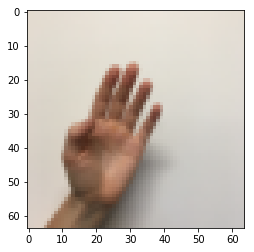

In [19]:
imgplot = plt.imshow(test['test_set_x'][25])

In [22]:
torch.save(model, "model.pt")

/home/surbhi/anaconda3/envs/pytorch-env/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Image_Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
